In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from deeplenstronomy.visualize import view_image, view_image_rgb
from astropy.io import fits
import autolens as al
import autolens.plot as aplt
import autofit as af

from lenstronomy.Data.psf import PSF
from lenstronomy.Util import util
from lenstronomy.Data.psf import PSF
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Util import param_util

#from ipywidgets import *
import time

num_simulated_lenses = 5000
bands_simulated = ['g', 'r', 'i', 'z', 'Y']

image_pre_path = './simulations/fits_files/'

%matplotlib inline

In [2]:
metadata = pd.read_csv(image_pre_path+'metadata.txt')
metadata.head()

,OBJID-g,H0-g,Om0-g,exposure_time-g,numPix-g,pixel_scale-g,psf_type-g,read_noise-g,ccd_gain-g,seeing-g,...,PLANE_1-REDSHIFT-g,PLANE_2-REDSHIFT-g,PLANE_1-REDSHIFT-r,PLANE_2-REDSHIFT-r,PLANE_1-REDSHIFT-i,PLANE_2-REDSHIFT-i,PLANE_1-REDSHIFT-z,PLANE_2-REDSHIFT-z,PLANE_1-REDSHIFT-Y,PLANE_2-REDSHIFT-Y
0,1,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,1.200,...,0.701759,2.613567,0.701759,2.613567,0.701759,2.613567,0.701759,2.613567,0.701759,2.613567
1,2,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,0.761,...,0.976595,2.997593,0.976595,2.997593,0.976595,2.997593,0.976595,2.997593,0.976595,2.997593
2,3,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,1.559,...,0.851417,1.342668,0.851417,1.342668,0.851417,1.342668,0.851417,1.342668,0.851417,1.342668
3,4,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,1.241,...,0.942661,3.862177,0.942661,3.862177,0.942661,3.862177,0.942661,3.862177,0.942661,3.862177
4,5,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,0.962,...,0.645495,4.738823,0.645495,4.738823,0.645495,4.738823,0.645495,4.738823,0.645495,4.738823


In [3]:
dl_results = pd.read_csv('./dl_results/DL_results.csv')
dl_results.head()

,sys,nsersic_pred,nsersic_true,rsersic_pred,rsersic_true,thetae_pred,thetae_true
0,1502.0,4.389782,4.017141,4.663924,3.533353,2.432914,2.618092
1,2587.0,5.477110,5.630247,6.433606,5.894580,3.495189,3.711217
2,2654.0,4.577913,5.355109,5.801272,5.338677,2.907392,2.862549
3,1056.0,4.407599,4.212606,8.003832,9.544011,4.699515,4.923458
4,706.0,3.396282,3.554883,6.845214,5.549851,2.992930,3.144579


In [4]:
limits = np.histogram(dl_results['thetae_true'], bins=50)[1]

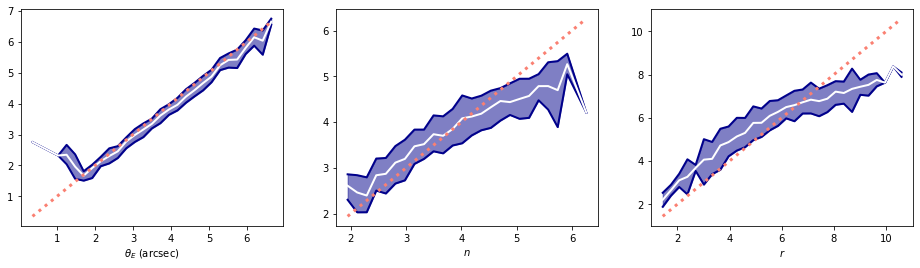

In [5]:
variables = ['thetae', 'nsersic', 'rsersic']
variables_lattex = ['$θ_E$ (arcsec)', '$n$', '$r$']

mean = []
upper_sigma = []
lower_sigma = []
X_ = []
saved_limits = []
for i in range(3):
    mean.append([])
    upper_sigma.append([])
    lower_sigma.append([])
    X_.append([])
    
for i in range(0, len(variables)):
    limits = np.histogram(dl_results[variables[i]+'_true'], bins=30)[1]
    saved_limits.append(limits)
    for j in range(0, len(limits)-1):
        if len(dl_results[variables[i]+'_pred'][(dl_results[variables[i]+'_true'] < limits[j+1]) & (dl_results[variables[i]+'_true'] > limits[j])]) > 0:
            mean[i].append(np.mean(dl_results[variables[i]+'_pred'][(dl_results[variables[i]+'_true'] < limits[j+1]) & (dl_results[variables[i]+'_true'] > limits[j])]))
            lower_error, upper_error = np.percentile(dl_results[variables[i]+'_pred'][(dl_results[variables[i]+'_true'] < limits[j+1]) & (dl_results[variables[i]+'_true'] > limits[j])], [15.85, 84.05])
            lower_sigma[i].append(lower_error)
            upper_sigma[i].append(upper_error)
            X_[i].append(limits[j] + (limits[i+1]-limits[i])/2)
    
fig, ax = plt.subplots(1, len(variables), figsize=(16, 4))
for i in range(0, len(variables)):
    ax[i].fill_between(np.array(X_[i]), np.array(lower_sigma[i]), np.array(upper_sigma[i]), color = 'darkblue', alpha=0.5, zorder=1)
    ax[i].plot(X_[i], np.array(lower_sigma[i]), 'darkblue', lw=2, zorder=2)
    ax[i].plot(X_[i], np.array(upper_sigma[i]), 'darkblue', lw=2, zorder=2)
    ax[i].plot(X_[i], mean[i], "w", lw=2, zorder=2)
    ax[i].plot(X_[i],X_[i], 'salmon', lw=3., linestyle='dotted', zorder=3)
    ax[i].set_xlabel(variables_lattex[i])

In [6]:
bayes_sys_fit = metadata.iloc[dl_results['sys']-1]
bayes_sys_fit = bayes_sys_fit[(bayes_sys_fit['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'] < 6.) & (bayes_sys_fit['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'] > 2.)]
bayes_sys_fit = bayes_sys_fit[(bayes_sys_fit['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-n_sersic-g'] < 4.5) & (bayes_sys_fit['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-n_sersic-g'] > 2.5)]
bayes_sys_fit = bayes_sys_fit[(bayes_sys_fit['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-R_sersic-g'] < 6.5) & (bayes_sys_fit['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-R_sersic-g'] > 3.5)]
bayes_sys_fit.reset_index(inplace=True)

In [7]:
dl_results.head()

,sys,nsersic_pred,nsersic_true,rsersic_pred,rsersic_true,thetae_pred,thetae_true
0,1502.0,4.389782,4.017141,4.663924,3.533353,2.432914,2.618092
1,2587.0,5.477110,5.630247,6.433606,5.894580,3.495189,3.711217
2,2654.0,4.577913,5.355109,5.801272,5.338677,2.907392,2.862549
3,1056.0,4.407599,4.212606,8.003832,9.544011,4.699515,4.923458
4,706.0,3.396282,3.554883,6.845214,5.549851,2.992930,3.144579


In [8]:
bayes_sys_fit.head()

,index,OBJID-g,H0-g,Om0-g,exposure_time-g,numPix-g,pixel_scale-g,psf_type-g,read_noise-g,ccd_gain-g,...,PLANE_1-REDSHIFT-g,PLANE_2-REDSHIFT-g,PLANE_1-REDSHIFT-r,PLANE_2-REDSHIFT-r,PLANE_1-REDSHIFT-i,PLANE_2-REDSHIFT-i,PLANE_1-REDSHIFT-z,PLANE_2-REDSHIFT-z,PLANE_1-REDSHIFT-Y,PLANE_2-REDSHIFT-Y
0,1501,1502,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,...,0.935053,3.726231,0.935053,3.726231,0.935053,3.726231,0.935053,3.726231,0.935053,3.726231
1,705,706,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,...,0.339738,4.820473,0.339738,4.820473,0.339738,4.820473,0.339738,4.820473,0.339738,4.820473
2,106,107,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,...,0.858379,2.855011,0.858379,2.855011,0.858379,2.855011,0.858379,2.855011,0.858379,2.855011
3,2464,2465,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,...,0.726914,4.242360,0.726914,4.242360,0.726914,4.242360,0.726914,4.242360,0.726914,4.242360
4,915,916,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,...,0.375647,1.763864,0.375647,1.763864,0.375647,1.763864,0.375647,1.763864,0.375647,1.763864


In [9]:
metadata.head()

,OBJID-g,H0-g,Om0-g,exposure_time-g,numPix-g,pixel_scale-g,psf_type-g,read_noise-g,ccd_gain-g,seeing-g,...,PLANE_1-REDSHIFT-g,PLANE_2-REDSHIFT-g,PLANE_1-REDSHIFT-r,PLANE_2-REDSHIFT-r,PLANE_1-REDSHIFT-i,PLANE_2-REDSHIFT-i,PLANE_1-REDSHIFT-z,PLANE_2-REDSHIFT-z,PLANE_1-REDSHIFT-Y,PLANE_2-REDSHIFT-Y
0,1,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,1.200,...,0.701759,2.613567,0.701759,2.613567,0.701759,2.613567,0.701759,2.613567,0.701759,2.613567
1,2,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,0.761,...,0.976595,2.997593,0.976595,2.997593,0.976595,2.997593,0.976595,2.997593,0.976595,2.997593
2,3,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,1.559,...,0.851417,1.342668,0.851417,1.342668,0.851417,1.342668,0.851417,1.342668,0.851417,1.342668
3,4,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,1.241,...,0.942661,3.862177,0.942661,3.862177,0.942661,3.862177,0.942661,3.862177,0.942661,3.862177
4,5,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,0.962,...,0.645495,4.738823,0.645495,4.738823,0.645495,4.738823,0.645495,4.738823,0.645495,4.738823


In [10]:
pixel_scale = bayes_sys_fit['pixel_scale-g'][0]
exposure_time = bayes_sys_fit['exposure_time-g'][0]
N_sys = 20

cutouts = []
psf = []
noise_map = []
for i in range(N_sys):
    cutouts.append ([])
    psf.append([])
    noise_map.append([])

for i in range(N_sys):
    for j in range(0, len(bands_simulated)):
        cutouts[i].append(fits.open(image_pre_path+bands_simulated[j]+'/'+str(bayes_sys_fit['OBJID-g'][i]-1)+'.fits')[0].data)
        kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': bayes_sys_fit['seeing-'+bands_simulated[j]][i], 'pixel_size': bayes_sys_fit['pixel_scale-g'][0], 'truncation': 4/bayes_sys_fit['seeing-'+bands_simulated[j]][i]}
        psf_class = PSF(**kwargs_psf)
        psf[i].append(psf_class.kernel_point_source/np.max(psf_class.kernel_point_source))
        noise_map[i].append(np.sqrt((cutouts[i][j]*exposure_time+float(bayes_sys_fit['sky_brightness-'+str(bands_simulated[j])][i]**2)))/exposure_time)

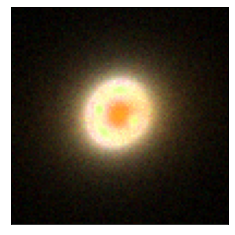

In [11]:
view_image_rgb(cutouts[0])

## building inner and outter lens light 

* lens light mask

In [12]:
image_model_optionlist = np.linspace(0, len(cutouts), len(cutouts)+1, dtype=int)

In [13]:
'''
def update_graph(n):
    """
    def function to update our visual graph
    i: int
        option, system
    """
    imaging_for_mask = al.Imaging(al.Array2D.manual(np.array(cutouts[n][2], dtype=float), pixel_scales=float(pixel_scale)), # cutout
                                  al.Array2D.manual(np.array(noise_map[n][2], dtype=float), pixel_scales=float(pixel_scale)), # noise_map 
                                  al.Kernel2D.manual(np.array(psf[n][2], dtype=float), pixel_scales=float(pixel_scale), shape_native=(100, 100))) # psf

    mask = al.Mask2D.circular(shape_native=imaging_for_mask.shape_native, pixel_scales=imaging_for_mask.pixel_scales, radius=1.2)
    imaging_for_mask = imaging_for_mask.apply_mask(mask=mask)

    visuals_2d = aplt.Visuals2D()
    array_plotter = aplt.Array2DPlotter(array=imaging_for_mask.image, visuals_2d=visuals_2d)
    array_plotter.figure_2d()
    
n = widgets.Dropdown(options=image_model_optionlist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,n = n)
'''

'\ndef update_graph(n):\n    """\n    def function to update our visual graph\n    i: int\n        option, system\n    """\n    imaging_for_mask = al.Imaging(al.Array2D.manual(np.array(cutouts[n][2], dtype=float), pixel_scales=float(pixel_scale)), # cutout\n                                  al.Array2D.manual(np.array(noise_map[n][2], dtype=float), pixel_scales=float(pixel_scale)), # noise_map \n                                  al.Kernel2D.manual(np.array(psf[n][2], dtype=float), pixel_scales=float(pixel_scale), shape_native=(100, 100))) # psf\n\n    mask = al.Mask2D.circular(shape_native=imaging_for_mask.shape_native, pixel_scales=imaging_for_mask.pixel_scales, radius=1.2)\n    imaging_for_mask = imaging_for_mask.apply_mask(mask=mask)\n\n    visuals_2d = aplt.Visuals2D()\n    array_plotter = aplt.Array2DPlotter(array=imaging_for_mask.image, visuals_2d=visuals_2d)\n    array_plotter.figure_2d()\n    \nn = widgets.Dropdown(options=image_model_optionlist, value=0, description=\'Component

* lens system mask

In [14]:
'''
def update_graph(n):
    """
    def function to update our visual graph
    i: int
        option, system
    """
    imaging_for_mask = al.Imaging(al.Array2D.manual(np.array(cutouts[n][0], dtype=float), pixel_scales=float(pixel_scale)), # cutout
                                  al.Array2D.manual(np.array(noise_map[n][0], dtype=float), pixel_scales=float(pixel_scale)), # noise_map 
                                  al.Kernel2D.manual(np.array(psf[n][0], dtype=float), pixel_scales=float(pixel_scale), shape_native=(100, 100))) # psf

    mask = al.Mask2D.circular(shape_native=imaging_for_mask.shape_native, pixel_scales=imaging_for_mask.pixel_scales, radius=8.0)
    imaging_for_mask = imaging_for_mask.apply_mask(mask=mask)

    visuals_2d = aplt.Visuals2D()
    array_plotter = aplt.Array2DPlotter(array=imaging_for_mask.image, visuals_2d=visuals_2d)
    array_plotter.figure_2d()
    
n = widgets.Dropdown(options=image_model_optionlist, value=0, description='Component:', disabled=False)

widgets.interactive(update_graph,n = n)
'''

'\ndef update_graph(n):\n    """\n    def function to update our visual graph\n    i: int\n        option, system\n    """\n    imaging_for_mask = al.Imaging(al.Array2D.manual(np.array(cutouts[n][0], dtype=float), pixel_scales=float(pixel_scale)), # cutout\n                                  al.Array2D.manual(np.array(noise_map[n][0], dtype=float), pixel_scales=float(pixel_scale)), # noise_map \n                                  al.Kernel2D.manual(np.array(psf[n][0], dtype=float), pixel_scales=float(pixel_scale), shape_native=(100, 100))) # psf\n\n    mask = al.Mask2D.circular(shape_native=imaging_for_mask.shape_native, pixel_scales=imaging_for_mask.pixel_scales, radius=8.0)\n    imaging_for_mask = imaging_for_mask.apply_mask(mask=mask)\n\n    visuals_2d = aplt.Visuals2D()\n    array_plotter = aplt.Array2DPlotter(array=imaging_for_mask.image, visuals_2d=visuals_2d)\n    array_plotter.figure_2d()\n    \nn = widgets.Dropdown(options=image_model_optionlist, value=0, description=\'Component

## modelization 

In [15]:
'''
class apply_pipeline:
    def __init__(self, imaging_object, system_identifier_name, lens_redshift, source_redshift, core_usage=5):
        
        self.imaging_object = imaging_object
        self.system_identifier_name = system_identifier_name
        self.lens_redshift = lens_redshift
        self.source_redshift = source_redshift
        self.core_usage = core_usage
        
    def rotate_matrix(self, m):
        return [[m[jj][ii] for jj in range(len(m))] for ii in range(len(m[0])-1,-1,-1)]
        
    def fit_lens_light(self, nlive, lens_light_radius=1.2):
        # applying a mask
        mask = al.Mask2D.circular(shape_native=self.imaging_object.shape_native, pixel_scales=self.imaging_object.pixel_scales, radius=lens_light_radius)
        masked_object = self.imaging_object.apply_mask(mask=mask)
        # model
        source_galaxy_model = af.Model(al.Galaxy,
                                       redshift=self.source_redshift)
        lens_bulge = af.Model(al.lmp.EllSersic)
        lens_galaxy_model = af.Model(al.Galaxy,
                                     redshift=self.lens_redshift,
                                     bulge_0=lens_bulge)
        # combining our previous components
        lens_light_model = af.Collection(galaxies=af.Collection(lens=lens_galaxy_model, source=source_galaxy_model))
        session = af.db.open_database("database.sqlite")
        # autolens fit full bright distribution
        
        search = af.DynestyStatic(path_prefix = './',
                                  session=session,
                                  name = str(self.system_identifier_name)+'_lens_light_step_0',
                                  unique_tag = str(self.system_identifier_name) + '_lens_light_step_0',
                                  nlive = nlive,
                                  number_of_cores = self.core_usage) # be carefull here! verify your core numbers
        
        search = af.Emcee(
            session=session,
            path_prefix='./',
            name=str(self.system_identifier_name)+'_lens_light_step_0',
            #unique_tag=dataset_name,
            nwalkers=50,
            nsteps=1000,
        )

        analysis = al.AnalysisImaging(dataset=masked_object)
        step_0_result = search.fit(model=lens_light_model, analysis=analysis)

        return step_0_result
    
    def fit_system_autolens(self, original_image, original_noise_map, original_psf, unmasked_lens_model, nlive, pixel_scale, prior_variables=[], predictions_dataframe=[], lower_limits=[], upper_limits=[], system_radius=8.0, use_predictions=False):
        original_image = al.Array2D.manual(np.array(original_image, dtype=float), pixel_scales=float(pixel_scale))
        residual_image = original_image - unmasked_lens_model
        new_image_object = al.Imaging(residual_image, # cutout
                                      al.Array2D.manual(np.array(original_noise_map, dtype=float), pixel_scales=float(pixel_scale)), # noise_map 
                                      al.Kernel2D.manual(np.array(original_psf, dtype=float), pixel_scales=float(pixel_scale), shape_native=(100, 100))) # psf

        mask = al.Mask2D.circular(shape_native=new_image_object.shape_native, pixel_scales=new_image_object.pixel_scales, radius=system_radius)
        masked_object = new_image_object.apply_mask(mask=mask)

        # source galaxy model
        bulge = af.Model(al.lmp.EllSersic)
        source_galaxy_model = af.Model(al.Galaxy,
                                       redshift=self.source_redshift,
                                       bulge=bulge)
        # lens galaxy model
        lens_galaxy_model = af.Model(al.Galaxy,
                                     redshift=self.lens_redshift ,
                                     mass=al.mp.EllIsothermal)    
        if use_predictions:
            priors = []
            for n in range(0, len(prior_variables)):
                priors.append([float(predictions_dataframe[prior_variables[n]+'_pred']-0.3*predictions_dataframe[prior_variables[n]+'_pred']), float(predictions_dataframe[prior_variables[n]+'_pred']+0.3*predictions_dataframe[prior_variables[n]+'_pred'])])
                
                
                lowest_index = np.where(np.abs(np.array(lower_limits[n])-float(predictions_dataframe[prior_variables[n]+'_pred'])) == np.min(np.abs(np.array(lower_limits[n])-float(predictions_dataframe[prior_variables[n]+'_pred']))))[0][0]
                highest_index = np.where(np.abs(np.array(upper_limits[n])-float(predictions_dataframe[prior_variables[n]+'_pred'])) == np.min(np.abs(np.array(upper_limits[n])-float(predictions_dataframe[prior_variables[n]+'_pred']))))[0][0]+1
                print('=============')
                print(lower_limits[n][lowest_index], upper_limits[n][highest_index])
                print(float(predictions_dataframe[prior_variables[n]+'_pred'])-lower_limits[n][lowest_index])
                print(float(predictions_dataframe[prior_variables[n]+'_pred'])-upper_limits[n][highest_index])
                priors.append([float(predictions_dataframe[prior_variables[n]+'_pred'])-2*np.abs(float(predictions_dataframe[prior_variables[n]+'_pred'])-lower_limits[n][lowest_index]), float(predictions_dataframe[prior_variables[n]+'_pred'])+2*np.abs(float(predictions_dataframe[prior_variables[n]+'_pred'])-upper_limits[n][highest_index])]) 
                
            lens_galaxy_model.mass.einstein_radius = af.UniformPrior(lower_limit=priors[0][0], upper_limit=priors[0][1])
            source_galaxy_model.bulge.sersic_index  = af.UniformPrior(lower_limit=priors[1][0], upper_limit=priors[1][1])
            source_galaxy_model.bulge.effective_radius = af.UniformPrior(lower_limit=priors[2][0], upper_limit=priors[2][1])
            

        autolens_model = af.Collection(galaxies=af.Collection(lens=lens_galaxy_model, source=source_galaxy_model))
        session = af.db.open_database("database.sqlite")
        # autolens fit full bright distribution
        
        search = af.DynestyStatic(path_prefix = './',
                                  session=session,
                                  name = str(self.system_identifier_name) + '_lens_light_step_1',
                                  unique_tag = str(self.system_identifier_name) + '_lens_light_step_1',
                                  nlive = nlive,
                                  number_of_cores = self.core_usage) # be carefull here! verify your core numbers
        
        search = af.Emcee(
            session=session,
            path_prefix='./',
            name=str(self.system_identifier_name)+'_lens_light_step_1',
            #unique_tag=dataset_name,
            nwalkers=50,
            nsteps=1000,
        )

        analysis = al.AnalysisImaging(dataset=masked_object)
        step_1_result = search.fit(model=autolens_model, analysis=analysis) # fbd = full bright distribution
        return step_1_result
    
    def fit_system_lenstronomy(self, original_image, background_rms, exposure_time, original_psf, unmasked_lens_model, pixel_scale, prior_variables=[], predictions_dataframe=[], lower_limits=[], upper_limits=[], system_radius=8.0, use_predictions=False):
        
        original_image = al.Array2D.manual(np.array(original_image, dtype=float), pixel_scales=float(pixel_scale))
        residual_image = original_image - unmasked_lens_model
        
        residual_image = np.array(residual_image).reshape(100, 100) # 100x100 image
        # here, we need to rotate our matrix, reshape brings this trouble to us
        residual_image = np.array(self.rotate_matrix(residual_image.T))
        residual_image = np.array(self.rotate_matrix(residual_image.T)) # another rotation
        
        # general configurations
        _, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=100, deltapix=pixel_scale, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)
        # models for lens, source and point-source
        lens_model = ['SIE']
        source_model = ['SERSIC_ELLIPSE']
        
        lens_model_class = LensModel(lens_model_list=lens_model)
        source_model_class = LightModel(light_model_list=source_model)
        
        # data input parameters
        kwargs_data = {'background_rms': background_rms,  # rms of background noise
                       'exposure_time': exposure_time,  # exposure time (or a map per pixel)
                       'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
                       'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
                       'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
                       'image_data': np.zeros((100, 100))  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
                      }
        
        # psf kwargs
        kwargs_psf = {'psf_type': 'PIXEL', 'pixel_size': pixel_scale, 'kernel_point_source': original_psf}
        psf_class = PSF(**kwargs_psf)
        # some fit parameters
        kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
        # seting image kwargs
        data_class = ImageData(**kwargs_data)
        data_class.update_data(residual_image)
        kwargs_data['image_data'] = residual_image
        
        # setting our priors
        ######## Lens ########
        fixed_lens = []
        kwargs_lens_init = []
        kwargs_lens_sigma = []
        kwargs_lower_lens = []
        kwargs_upper_lens = []

        # initial guess, sigma, upper and lower parameters
        fixed_lens.append({})
        kwargs_lens_init.append({'theta_E': 3.3, 'e1': 0.07, 'e2': 0.03, # Einstein radius, eccentricity and lens positions
                                 'center_x': 0., 'center_y': 0.})
        kwargs_lens_sigma.append({'theta_E': 1., 'e1': 0.5, 'e2': 0.05, # 1-sigma values
                                 'center_x': 0.05, 'center_y': 0.05}) 
        # upper and lower bounds
        kwargs_lower_lens.append({'theta_E': 1., 'e1': -0.7, 'e2': -0.7, 'center_x': -10., 'center_y': -10})
        kwargs_upper_lens.append({'theta_E': 5., 'e1': 0.7, 'e2': 0.7, 'center_x': 10., 'center_y': 10})

        # intitial guess for the lens positions
        fixed_lens.append({'ra_0': 0, 'dec_0': 0})
        # gamma parameters, initial guess, sigma, upper and lower bounds
        kwargs_lens_init.append({'gamma1': 0., 'gamma2': 0.0})
        kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
        kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
        kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})

        # creating an object to have all this attributes
        lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

        ######## Lens ########
        fixed_source = []
        kwargs_source_init = []
        kwargs_source_sigma = []
        kwargs_lower_source = []
        kwargs_upper_source = []

        # initial guess, sigma, upper and lower parameters
        fixed_source.append({})
        kwargs_source_init.append({'R_sersic': 6., 'n_sersic': 4, 'e1': 0., 'e2': 0., 'center_x': 0., 'center_y': 0}) # R sersic parameter, n sersic index, eccentricities and x and y centers
        kwargs_source_sigma.append({'n_sersic': 2., 'R_sersic': 2., 'e1': 0.5, 'e2': 0.5, 'center_x': 0.2, 'center_y': 0.2}) # 1-sigma values
        # upper and lower bounds
        kwargs_lower_source.append({'e1': -1., 'e2': -1., 'R_sersic': 1., 'n_sersic': 1., 'center_x': -10, 'center_y': -10})
        kwargs_upper_source.append({'e1': 1., 'e2': 1., 'R_sersic': 10, 'n_sersic': 6., 'center_x': 10, 'center_y': 10})

        # creating an object to have all this attributes
        source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

        ######## Lens light (or bulge) ########  
        fixed_lens_light = []
        kwargs_lens_light_init = []
        kwargs_lens_light_sigma = []
        kwargs_lower_lens_light = []
        kwargs_upper_lens_light = []

        fixed_lens_light.append({})
        kwargs_lens_light_init.append({'amp':1., 'R_sersic': 6., 'n_sersic': 4., 'e1': 0., 'e2': 0, 'center_x': 0., 'center_y': 0}) # flux amplitude (not really important), R sersic parameter, n sersic index xparameter, eccentricities and x and y centers
        kwargs_lens_light_sigma.append({'amp':1., 'n_sersic': 2., 'R_sersic': 2., 'e1': 0.5, 'e2': 0.5, 'center_x': 0.1, 'center_y': 0.1}) # 1-sigma values
        # upper and lower bounds
        kwargs_lower_lens_light.append({'amp':1., 'e1': -1., 'e2': -0.5, 'R_sersic': 1., 'n_sersic': 1., 'center_x': -10, 'center_y': -10})
        kwargs_upper_lens_light.append({'amp':1., 'e1': 1., 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 6., 'center_x': 10, 'center_y': 10})

        # creating an object to have all this attributes
        lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

        # setting lens and source parameters (Einstein raidius, eccentricities, R sersic, etc)
        kwargs_params = {'lens_model': lens_params,
                        'source_model': source_params}

        # Likelihood kwargs
        kwargs_likelihood = {'source_marg': False}
        kwargs_model = {'lens_model_list': lens_model, 'source_light_model_list': source_model}
        # here, we have 1 single band to fit
        multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]
        # if you have multiple  bands to be modeled simultaneously, you can append them to the mutli_band_list
        kwargs_data_joint = {'multi_band_list': multi_band_list, 
                             'multi_band_type': 'multi-linear'}  # 'multi-linear': every imaging band has independent solutions of the surface brightness, 'joint-linear': there is one joint solution of the linear coefficients demanded across the bands.
        # we dont have a contraint
        kwargs_constraints = {}

        # running an mcmc algorithm
        fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)
        fitting_kwargs_list = [['MCMC', {'n_burn': 200, 'n_run': 800, 'walkerRatio': 10, 'sigma_scale': .1}]]
        fbd_lenstronomy = fitting_seq.fit_sequence(fitting_kwargs_list)
        kwargs_fbd_result = fitting_seq.best_fit()
        
        # building a pandas dataframe and a fits file
        results_path = './output_lenstronomy/'
        fbd_lenstronomy_chain = pd.DataFrame(fbd_lenstronomy[0][1].T, fbd_lenstronomy[0][2])
        fbd_lenstronomy_chain = fbd_lenstronomy_chain.T
        fbd_lenstronomy_chain.to_csv(results_path+str(self.system_identifier_name)+'.csv')
        
        imageModel = ImageModel(data_class, psf_class, lens_model_class,
                                source_model_class,
                                kwargs_numerics=kwargs_numerics)
        image = imageModel.image(kwargs_lens=kwargs_fbd_result['kwargs_lens'], kwargs_source=kwargs_fbd_result['kwargs_source'])
        return fbd_lenstronomy, image
    
    def reset_all(self):
        self.imaging_object = None
        self.system_identifier_name = None
        self.lens_redshift = None
        self.source_redshift = None
        self.core_usage = None
        
'''

In [16]:
bayes_sys_fit

,index,OBJID-g,H0-g,Om0-g,exposure_time-g,numPix-g,pixel_scale-g,psf_type-g,read_noise-g,ccd_gain-g,...,PLANE_1-REDSHIFT-g,PLANE_2-REDSHIFT-g,PLANE_1-REDSHIFT-r,PLANE_2-REDSHIFT-r,PLANE_1-REDSHIFT-i,PLANE_2-REDSHIFT-i,PLANE_1-REDSHIFT-z,PLANE_2-REDSHIFT-z,PLANE_1-REDSHIFT-Y,PLANE_2-REDSHIFT-Y
0,1501,1502,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,...,0.935053,3.726231,0.935053,3.726231,0.935053,3.726231,0.935053,3.726231,0.935053,3.726231
1,705,706,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,...,0.339738,4.820473,0.339738,4.820473,0.339738,4.820473,0.339738,4.820473,0.339738,4.820473
2,106,107,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,...,0.858379,2.855011,0.858379,2.855011,0.858379,2.855011,0.858379,2.855011,0.858379,2.855011
3,2464,2465,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,...,0.726914,4.242360,0.726914,4.242360,0.726914,4.242360,0.726914,4.242360,0.726914,4.242360
4,915,916,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,...,0.375647,1.763864,0.375647,1.763864,0.375647,1.763864,0.375647,1.763864,0.375647,1.763864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,4849,4850,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,...,0.305379,4.080111,0.305379,4.080111,0.305379,4.080111,0.305379,4.080111,0.305379,4.080111
374,1268,1269,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,...,0.399126,4.147677,0.399126,4.147677,0.399126,4.147677,0.399126,4.147677,0.399126,4.147677
375,2307,2308,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,...,0.475610,3.715020,0.475610,3.715020,0.475610,3.715020,0.475610,3.715020,0.475610,3.715020
376,2732,2733,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,...,0.949194,5.615435,0.949194,5.615435,0.949194,5.615435,0.949194,5.615435,0.949194,5.615435


In [17]:
bayes_sys_fit.to_csv('./modelized_systems.csv')

In [18]:
al.lmp.SphSersic

autogalaxy.profiles.light_and_mass_profiles.SphSersic

In [19]:
'''
taking_time = []
for i in range(0, N_sys):
    start = time.time()
    print(bayes_sys_fit['OBJID-g'][i])
    predictions_dataframe = dl_results[dl_results['sys']==bayes_sys_fit['OBJID-g'][i]]
    lower_limits=lower_sigma
    upper_limits=upper_sigma
    
    imaging_0 = al.Imaging(al.Array2D.manual(np.array(cutouts[i][2], dtype=float), pixel_scales=float(pixel_scale)), # cutout
                           al.Array2D.manual(np.array(noise_map[i][2], dtype=float), pixel_scales=float(pixel_scale)), # noise_map 
                           al.Kernel2D.manual(np.array(psf[i][2], dtype=float), pixel_scales=float(pixel_scale), shape_native=(100, 100))) # psf
    zl = bayes_sys_fit['PLANE_1-REDSHIFT-g'][i]
    zs = bayes_sys_fit['PLANE_2-REDSHIFT-g'][i]
    
    mask = al.Mask2D.circular(shape_native=imaging_0.shape_native, pixel_scales=imaging_0.pixel_scales, radius=1.2)
    masked_object = imaging_0.apply_mask(mask=mask)
    
    source_galaxy_model = af.Model(al.Galaxy,
                                   redshift=zs)
    lens_bulge = af.Model(al.lmp.EllSersic)
    lens_galaxy_model = af.Model(al.Galaxy,
                                 redshift=zl,
                                 bulge_0=lens_bulge)
    # combining our previous components
    lens_light_model = af.Collection(galaxies=af.Collection(lens=lens_galaxy_model, source=source_galaxy_model))
    #session = af.db.open_database("database.sqlite")
    # autolens fit full bright distribution

    
    ###
    search = af.DynestyStatic(path_prefix = './',
                              #unique_tag = str(i)+'_lens_light_step_0',
                              name = str(i)+'_lens_light_step_0',
                              nlive = 30,
                              number_of_cores = 5) # be carefull here! verify your core numbers
    ###
    session = af.db.open_database("database.sqlite")
    search = af.Emcee(
        session=session,
        path_prefix='./',
        name=str(i)+'_lens_light_step_0',
        #unique_tag=dataset_name,
        nwalkers=50,
        nsteps=1000,
    )
    
    
    analysis = al.AnalysisImaging(dataset=masked_object)
    step_0_result = search.fit(model=lens_light_model, analysis=analysis)  

    original_image = al.Array2D.manual(np.array(cutouts[i][2], dtype=float), pixel_scales=float(pixel_scale))
    residual_image = original_image - step_0_result.unmasked_model_image
    new_image_object = al.Imaging(residual_image, # cutout
                                  al.Array2D.manual(np.array(noise_map[i][2], dtype=float), pixel_scales=float(pixel_scale)), # noise_map 
                                  al.Kernel2D.manual(np.array(psf[i][2], dtype=float), pixel_scales=float(pixel_scale), shape_native=(100, 100))) # psf

    

    mask = al.Mask2D.circular(shape_native=new_image_object.shape_native, pixel_scales=new_image_object.pixel_scales, radius=8.)
    masked_object = new_image_object.apply_mask(mask=mask)

    # source galaxy model
    bulge = af.Model(al.lmp.EllSersic)
    source_galaxy_model = af.Model(al.Galaxy,
                                   redshift=zs,
                                       bulge=bulge)
    # lens galaxy model
    lens_galaxy_model = af.Model(al.Galaxy,
                                 redshift=zl,
                                 mass=al.mp.EllIsothermal)    
    priors = []
    for n in range(0, len(variables)):
        priors.append([float(predictions_dataframe[variables[n]+'_pred']-0.3*predictions_dataframe[variables[n]+'_pred']), float(predictions_dataframe[variables[n]+'_pred']+0.3*predictions_dataframe[variables[n]+'_pred'])])
        #priors.append([float(predictions_dataframe[variables[n]+'_pred'])])

        ###
        lowest_index = np.where(np.abs(np.array(lower_limits[n])-float(predictions_dataframe[prior_variables[n]+'_pred'])) == np.min(np.abs(np.array(lower_limits[n])-float(predictions_dataframe[prior_variables[n]+'_pred']))))[0][0]
        highest_index = np.where(np.abs(np.array(upper_limits[n])-float(predictions_dataframe[prior_variables[n]+'_pred'])) == np.min(np.abs(np.array(upper_limits[n])-float(predictions_dataframe[prior_variables[n]+'_pred']))))[0][0]+1
        print('=============')
        print(lower_limits[n][lowest_index], upper_limits[n][highest_index])
        print(float(predictions_dataframe[prior_variables[n]+'_pred'])-lower_limits[n][lowest_index])
        print(float(predictions_dataframe[prior_variables[n]+'_pred'])-upper_limits[n][highest_index])
        priors.append([float(predictions_dataframe[prior_variables[n]+'_pred'])-2*np.abs(float(predictions_dataframe[prior_variables[n]+'_pred'])-lower_limits[n][lowest_index]), float(predictions_dataframe[prior_variables[n]+'_pred'])+2*np.abs(float(predictions_dataframe[prior_variables[n]+'_pred'])-upper_limits[n][highest_index])]) 
        ###
    #lens_galaxy_model.mass.einstein_radius = af.UniformPrior(lower_limit=priors[0][0], upper_limit=priors[0][1])
    #source_galaxy_model.bulge.sersic_index  = af.UniformPrior(lower_limit=priors[1][0], upper_limit=priors[1][1])
    #source_galaxy_model.bulge.effective_radius = af.UniformPrior(lower_limit=priors[2][0], upper_limit=priors[2][1])
    ###
    lens_galaxy_model.mass.einstein_radius = af.GaussianPrior(mean=priors[0][0],
                                                              sigma=np.abs(priors[0][0]*0.1),
                                                              lower_limit=-np.inf,
                                                              upper_limit=np.inf)
    
    source_galaxy_model.bulge.sersic_index = af.GaussianPrior(mean=priors[1][0],
                                                              sigma=np.abs(priors[1][0]*0.1),
                                                              lower_limit=-np.inf,
                                                              upper_limit=np.inf)

    source_galaxy_model.bulge.effective_radius = af.GaussianPrior(mean=priors[2][0],
                                                                  sigma=np.abs(priors[2][0]*0.1),
                                                                  lower_limit=-np.inf,
                                                                  upper_limit=np.inf)
    ###
    autolens_model = af.Collection(galaxies=af.Collection(lens=lens_galaxy_model, source=source_galaxy_model))
    #session = af.db.open_database("database.sqlite")
    # autolens fit full bright distribution
    
    
    ###
    search = af.DynestyStatic(path_prefix = './',
                              #unique_tag = str(i) + '_lens_light_step_1',
                              name = str(i)+'_lens_light_step_1',
                              nlive = 30,
                              number_of_cores = 5) # be carefull here! verify your core numbers
    ###
    session = af.db.open_database("database.sqlite")
    search = af.Emcee(
        session=session,
        path_prefix='./',
        name=str(i)+'_lens_light_step_1',
        #unique_tag=dataset_name,
        nwalkers=50,
        nsteps=1000,
    )
    
    
    
    analysis = al.AnalysisImaging(dataset=masked_object)
    step_1_result = search.fit(model=autolens_model, analysis=analysis) # fbd = full bright distribution

    end = time.time()
    taking_time.append(end - start)
    
    fig, ax = plt.subplots(1, 5,figsize=(16, 4))

    ax[0].imshow(cutouts[i][2])
    ax[0].text(75, 90, '5\" ', c='w', size=18)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].imshow(step_0_result.unmasked_model_image.reshape(100, 100))
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[2].imshow((imaging_0.image-step_0_result.unmasked_model_image).reshape(100, 100))
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    ax[3].imshow(step_1_result.unmasked_model_image.reshape(100, 100))
    ax[3].set_xticks([])
    ax[3].set_yticks([])
    ax[4].imshow((imaging_0.image-step_0_result.unmasked_model_image - step_1_result.unmasked_model_image).reshape(100, 100))
    ax[4].set_xticks([])
    ax[4].set_yticks([])

    fig.savefig('./imagens/'+str(i)+'.png');
'''

'\ntaking_time = []\nfor i in range(0, N_sys):\n    start = time.time()\n    print(bayes_sys_fit[\'OBJID-g\'][i])\n    predictions_dataframe = dl_results[dl_results[\'sys\']==bayes_sys_fit[\'OBJID-g\'][i]]\n    lower_limits=lower_sigma\n    upper_limits=upper_sigma\n    \n    imaging_0 = al.Imaging(al.Array2D.manual(np.array(cutouts[i][2], dtype=float), pixel_scales=float(pixel_scale)), # cutout\n                           al.Array2D.manual(np.array(noise_map[i][2], dtype=float), pixel_scales=float(pixel_scale)), # noise_map \n                           al.Kernel2D.manual(np.array(psf[i][2], dtype=float), pixel_scales=float(pixel_scale), shape_native=(100, 100))) # psf\n    zl = bayes_sys_fit[\'PLANE_1-REDSHIFT-g\'][i]\n    zs = bayes_sys_fit[\'PLANE_2-REDSHIFT-g\'][i]\n    \n    mask = al.Mask2D.circular(shape_native=imaging_0.shape_native, pixel_scales=imaging_0.pixel_scales, radius=1.2)\n    masked_object = imaging_0.apply_mask(mask=mask)\n    \n    source_galaxy_model = af.Model(al

In [20]:
taking_time = []
start = time.time()
for i in range(0, 0):
    imaging_0 = al.Imaging(al.Array2D.manual(np.array(cutouts[i][2], dtype=float), pixel_scales=float(pixel_scale)), # cutout
                       al.Array2D.manual(np.array(noise_map[i][2], dtype=float), pixel_scales=float(pixel_scale)), # noise_map 
                       al.Kernel2D.manual(np.array(psf[i][2], dtype=float), pixel_scales=float(pixel_scale), shape_native=(100, 100))) # psf
    zl = bayes_sys_fit['PLANE_1-REDSHIFT-g'][i]
    zs = bayes_sys_fit['PLANE_2-REDSHIFT-g'][i]
    pipeline = apply_pipeline(imaging_0, i, zl, zs)
    result = apply_pipeline.fit_lens_light(pipeline, nlive=30, lens_light_radius=1.2)
    result_modelization = pipeline.fit_system_autolens(cutouts[i][2], noise_map[i][2], psf[i][2], result.unmasked_model_image, nlive=30, pixel_scale=pixel_scale, prior_variables=variables, predictions_dataframe=dl_results[dl_results['sys']==bayes_sys_fit['OBJID-g'][i]], lower_limits=lower_sigma, upper_limits=upper_sigma, use_predictions=True)
    pipeline.reset_all()

    fig, ax = plt.subplots(1, 5,figsize=(16, 4))

    ax[0].imshow(cutouts[i][2])
    ax[0].text(75, 90, '5\" ', c='w', size=18)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].imshow(result.unmasked_model_image.reshape(100, 100))
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[2].imshow((imaging_0.image-result.unmasked_model_image).reshape(100, 100))
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    ax[3].imshow(result_modelization.unmasked_model_image.reshape(100, 100))
    ax[3].set_xticks([])
    ax[3].set_yticks([])
    ax[4].imshow((imaging_0.image-result.unmasked_model_image - result_modelization.unmasked_model_image).reshape(100, 100))
    ax[4].set_xticks([])
    ax[4].set_yticks([])

    fig.savefig('./imagens/'+str(i)+'.png');
    
end = time.time()
taking_time.append(end - start)

In [21]:
taking_time_df = pd.Series(taking_time)

In [22]:
taking_time_df.to_csv('./output/time_to_run.csv')

2022-03-30 14:47:11,424 - autoarray.dataset.imaging - INFO - IMAGING - Data masked, contains a total of 68 image-pixels
2022-03-30 14:47:11,522 - autofit.database.migration.migration - INFO - Database already at latest revision
2022-03-30 14:47:11,523 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-30 14:47:11,525 - 0_lens_light_step_0 - INFO - Starting search
2022-03-30 14:47:11,642 - 0_lens_light_step_0 - INFO - Already completed, skipping non-linear search.
2022-03-30 14:47:11,885 - 0_lens_light_step_0 - INFO - Removing zip file
2022-03-30 14:47:12,132 - lenstronomy.Sampling.Pool.pool - INFO - Running with SerialPool


100%|███████████████████████████████████████| 1000/1000 [03:39<00:00,  4.56it/s]


Computing the MCMC...
Number of walkers =  110
Burn-in iterations:  200
Sampling iterations (in current run): 1000
219.74455666542053 time taken for MCMC sampling
2022-03-30 14:50:53,728 - autoarray.dataset.imaging - INFO - IMAGING - Data masked, contains a total of 68 image-pixels
2022-03-30 14:50:53,860 - autofit.database.migration.migration - INFO - Database already at latest revision
2022-03-30 14:50:53,862 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-30 14:50:53,864 - 1_lens_light_step_0 - INFO - Starting search
2022-03-30 14:50:53,999 - 1_lens_light_step_0 - INFO - Already completed, skipping non-linear search.
2022-03-30 14:50:54,347 - 1_lens_light_step_0 - INFO - Removing zip file
2022-03-30 14:50:54,513 - lenstronomy.Sampling.Pool.pool - INFO - Running with SerialPool


100%|███████████████████████████████████████| 1000/1000 [02:36<00:00,  6.40it/s]


Computing the MCMC...
Number of walkers =  110
Burn-in iterations:  200
Sampling iterations (in current run): 1000
156.5257008075714 time taken for MCMC sampling
2022-03-30 14:53:32,593 - autoarray.dataset.imaging - INFO - IMAGING - Data masked, contains a total of 68 image-pixels
2022-03-30 14:53:32,717 - autofit.database.migration.migration - INFO - Database already at latest revision
2022-03-30 14:53:32,720 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-30 14:53:32,723 - 2_lens_light_step_0 - INFO - Starting search
2022-03-30 14:53:32,843 - 2_lens_light_step_0 - INFO - Already completed, skipping non-linear search.
2022-03-30 14:53:33,206 - 2_lens_light_step_0 - INFO - Removing zip file
2022-03-30 14:53:33,398 - lenstronomy.Sampling.Pool.pool - INFO - Running with SerialPool


100%|███████████████████████████████████████| 1000/1000 [03:21<00:00,  4.96it/s]


Computing the MCMC...
Number of walkers =  110
Burn-in iterations:  200
Sampling iterations (in current run): 1000
201.97053790092468 time taken for MCMC sampling
2022-03-30 14:56:56,977 - autoarray.dataset.imaging - INFO - IMAGING - Data masked, contains a total of 68 image-pixels
2022-03-30 14:56:57,069 - autofit.database.migration.migration - INFO - Database already at latest revision
2022-03-30 14:56:57,070 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-30 14:56:57,071 - 3_lens_light_step_0 - INFO - Starting search
2022-03-30 14:56:57,155 - 3_lens_light_step_0 - INFO - Already completed, skipping non-linear search.
2022-03-30 14:56:57,409 - 3_lens_light_step_0 - INFO - Removing zip file
2022-03-30 14:56:57,541 - lenstronomy.Sampling.Pool.pool - INFO - Running with SerialPool


100%|███████████████████████████████████████| 1000/1000 [03:49<00:00,  4.36it/s]


Computing the MCMC...
Number of walkers =  110
Burn-in iterations:  200
Sampling iterations (in current run): 1000
229.71009516716003 time taken for MCMC sampling
2022-03-30 15:00:48,503 - autoarray.dataset.imaging - INFO - IMAGING - Data masked, contains a total of 68 image-pixels
2022-03-30 15:00:48,594 - autofit.database.migration.migration - INFO - Database already at latest revision
2022-03-30 15:00:48,595 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-30 15:00:48,596 - 4_lens_light_step_0 - INFO - Starting search
2022-03-30 15:00:48,682 - 4_lens_light_step_0 - INFO - Already completed, skipping non-linear search.
2022-03-30 15:00:48,986 - 4_lens_light_step_0 - INFO - Removing zip file
2022-03-30 15:00:49,154 - lenstronomy.Sampling.Pool.pool - INFO - Running with SerialPool


100%|███████████████████████████████████████| 1000/1000 [03:21<00:00,  4.97it/s]


Computing the MCMC...
Number of walkers =  110
Burn-in iterations:  200
Sampling iterations (in current run): 1000
201.4505524635315 time taken for MCMC sampling
2022-03-30 15:04:12,685 - autoarray.dataset.imaging - INFO - IMAGING - Data masked, contains a total of 68 image-pixels
2022-03-30 15:04:12,853 - autofit.database.migration.migration - INFO - Database already at latest revision
2022-03-30 15:04:12,854 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-30 15:04:12,855 - 5_lens_light_step_0 - INFO - Starting search
2022-03-30 15:04:12,966 - 5_lens_light_step_0 - INFO - Already completed, skipping non-linear search.
2022-03-30 15:04:13,455 - 5_lens_light_step_0 - INFO - Removing zip file
2022-03-30 15:04:13,644 - lenstronomy.Sampling.Pool.pool - INFO - Running with SerialPool


100%|███████████████████████████████████████| 1000/1000 [02:33<00:00,  6.50it/s]


Computing the MCMC...
Number of walkers =  110
Burn-in iterations:  200
Sampling iterations (in current run): 1000
154.1209614276886 time taken for MCMC sampling
2022-03-30 15:06:49,101 - autoarray.dataset.imaging - INFO - IMAGING - Data masked, contains a total of 68 image-pixels
2022-03-30 15:06:49,203 - autofit.database.migration.migration - INFO - Database already at latest revision
2022-03-30 15:06:49,204 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-30 15:06:49,205 - 6_lens_light_step_0 - INFO - Starting search
2022-03-30 15:06:49,302 - 6_lens_light_step_0 - INFO - Already completed, skipping non-linear search.
2022-03-30 15:06:49,599 - 6_lens_light_step_0 - INFO - Removing zip file
2022-03-30 15:06:49,751 - lenstronomy.Sampling.Pool.pool - INFO - Running with SerialPool


100%|███████████████████████████████████████| 1000/1000 [03:07<00:00,  5.33it/s]


Computing the MCMC...
Number of walkers =  110
Burn-in iterations:  200
Sampling iterations (in current run): 1000
187.8349061012268 time taken for MCMC sampling
2022-03-30 15:09:58,865 - autoarray.dataset.imaging - INFO - IMAGING - Data masked, contains a total of 68 image-pixels
2022-03-30 15:09:58,961 - autofit.database.migration.migration - INFO - Database already at latest revision
2022-03-30 15:09:58,962 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-30 15:09:58,963 - 7_lens_light_step_0 - INFO - Starting search
2022-03-30 15:09:59,045 - 7_lens_light_step_0 - INFO - Already completed, skipping non-linear search.
2022-03-30 15:09:59,347 - 7_lens_light_step_0 - INFO - Removing zip file
2022-03-30 15:09:59,504 - lenstronomy.Sampling.Pool.pool - INFO - Running with SerialPool


100%|███████████████████████████████████████| 1000/1000 [02:14<00:00,  7.41it/s]


Computing the MCMC...
Number of walkers =  110
Burn-in iterations:  200
Sampling iterations (in current run): 1000
135.21884655952454 time taken for MCMC sampling
2022-03-30 15:12:15,985 - autoarray.dataset.imaging - INFO - IMAGING - Data masked, contains a total of 68 image-pixels
2022-03-30 15:12:16,078 - autofit.database.migration.migration - INFO - Database already at latest revision
2022-03-30 15:12:16,079 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-30 15:12:16,080 - 8_lens_light_step_0 - INFO - Starting search
2022-03-30 15:12:16,168 - 8_lens_light_step_0 - INFO - Already completed, skipping non-linear search.
2022-03-30 15:12:16,449 - 8_lens_light_step_0 - INFO - Removing zip file
2022-03-30 15:12:16,581 - lenstronomy.Sampling.Pool.pool - INFO - Running with SerialPool


100%|███████████████████████████████████████| 1000/1000 [02:01<00:00,  8.25it/s]


Computing the MCMC...
Number of walkers =  110
Burn-in iterations:  200
Sampling iterations (in current run): 1000
121.46262001991272 time taken for MCMC sampling
2022-03-30 15:14:19,285 - autoarray.dataset.imaging - INFO - IMAGING - Data masked, contains a total of 68 image-pixels
2022-03-30 15:14:19,381 - autofit.database.migration.migration - INFO - Database already at latest revision
2022-03-30 15:14:19,382 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-30 15:14:19,383 - 9_lens_light_step_0 - INFO - Starting search
2022-03-30 15:14:19,475 - 9_lens_light_step_0 - INFO - Already completed, skipping non-linear search.
2022-03-30 15:14:19,613 - 9_lens_light_step_0 - INFO - Removing zip file
2022-03-30 15:14:19,779 - lenstronomy.Sampling.Pool.pool - INFO - Running with SerialPool


100%|███████████████████████████████████████| 1000/1000 [03:43<00:00,  4.47it/s]


Computing the MCMC...
Number of walkers =  110
Burn-in iterations:  200
Sampling iterations (in current run): 1000
223.7879102230072 time taken for MCMC sampling
2022-03-30 15:18:05,034 - autoarray.dataset.imaging - INFO - IMAGING - Data masked, contains a total of 68 image-pixels
2022-03-30 15:18:05,130 - autofit.database.migration.migration - INFO - Database already at latest revision
2022-03-30 15:18:05,131 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-30 15:18:05,133 - 10_lens_light_step_0 - INFO - Starting search
2022-03-30 15:18:05,230 - 10_lens_light_step_0 - INFO - Already completed, skipping non-linear search.
2022-03-30 15:18:05,537 - 10_lens_light_step_0 - INFO - Removing zip file
2022-03-30 15:18:05,702 - lenstronomy.Sampling.Pool.pool - INFO - Running with SerialPool


100%|███████████████████████████████████████| 1000/1000 [02:12<00:00,  7.55it/s]


Computing the MCMC...
Number of walkers =  110
Burn-in iterations:  200
Sampling iterations (in current run): 1000
132.70062160491943 time taken for MCMC sampling
2022-03-30 15:20:19,735 - autoarray.dataset.imaging - INFO - IMAGING - Data masked, contains a total of 68 image-pixels
2022-03-30 15:20:19,833 - autofit.database.migration.migration - INFO - Database already at latest revision
2022-03-30 15:20:19,835 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-30 15:20:19,836 - 11_lens_light_step_0 - INFO - Starting search
2022-03-30 15:20:19,926 - 11_lens_light_step_0 - INFO - Already completed, skipping non-linear search.
2022-03-30 15:20:20,266 - 11_lens_light_step_0 - INFO - Removing zip file
2022-03-30 15:20:20,406 - lenstronomy.Sampling.Pool.pool - INFO - Running with SerialPool


100%|███████████████████████████████████████| 1000/1000 [03:36<00:00,  4.63it/s]


Computing the MCMC...
Number of walkers =  110
Burn-in iterations:  200
Sampling iterations (in current run): 1000
216.329509973526 time taken for MCMC sampling
2022-03-30 15:23:58,222 - autoarray.dataset.imaging - INFO - IMAGING - Data masked, contains a total of 68 image-pixels
2022-03-30 15:23:58,403 - autofit.database.migration.migration - INFO - Database already at latest revision
2022-03-30 15:23:58,404 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-30 15:23:58,406 - 12_lens_light_step_0 - INFO - Starting search
2022-03-30 15:23:58,554 - 12_lens_light_step_0 - INFO - Already completed, skipping non-linear search.
2022-03-30 15:23:58,723 - 12_lens_light_step_0 - INFO - Removing zip file
2022-03-30 15:23:58,911 - lenstronomy.Sampling.Pool.pool - INFO - Running with SerialPool


100%|███████████████████████████████████████| 1000/1000 [02:40<00:00,  6.22it/s]


Computing the MCMC...
Number of walkers =  110
Burn-in iterations:  200
Sampling iterations (in current run): 1000
160.94694781303406 time taken for MCMC sampling
2022-03-30 15:26:41,219 - autoarray.dataset.imaging - INFO - IMAGING - Data masked, contains a total of 68 image-pixels
2022-03-30 15:26:41,566 - autofit.database.migration.migration - INFO - Database already at latest revision
2022-03-30 15:26:41,567 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-30 15:26:41,569 - 13_lens_light_step_0 - INFO - Starting search
2022-03-30 15:26:41,670 - 13_lens_light_step_0 - INFO - Already completed, skipping non-linear search.
2022-03-30 15:26:41,985 - 13_lens_light_step_0 - INFO - Removing zip file
2022-03-30 15:26:42,137 - lenstronomy.Sampling.Pool.pool - INFO - Running with SerialPool


100%|███████████████████████████████████████| 1000/1000 [03:01<00:00,  5.50it/s]


Computing the MCMC...
Number of walkers =  110
Burn-in iterations:  200
Sampling iterations (in current run): 1000
182.1089220046997 time taken for MCMC sampling
2022-03-30 15:29:45,493 - autoarray.dataset.imaging - INFO - IMAGING - Data masked, contains a total of 68 image-pixels
2022-03-30 15:29:45,586 - autofit.database.migration.migration - INFO - Database already at latest revision
2022-03-30 15:29:45,587 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-30 15:29:45,588 - 14_lens_light_step_0 - INFO - Starting search
2022-03-30 15:29:45,671 - 14_lens_light_step_0 - INFO - Already completed, skipping non-linear search.
2022-03-30 15:29:45,808 - 14_lens_light_step_0 - INFO - Removing zip file
2022-03-30 15:29:45,960 - lenstronomy.Sampling.Pool.pool - INFO - Running with SerialPool


100%|███████████████████████████████████████| 1000/1000 [02:10<00:00,  7.67it/s]


Computing the MCMC...
Number of walkers =  110
Burn-in iterations:  200
Sampling iterations (in current run): 1000
130.6835150718689 time taken for MCMC sampling
2022-03-30 15:31:57,920 - autoarray.dataset.imaging - INFO - IMAGING - Data masked, contains a total of 68 image-pixels
2022-03-30 15:31:58,210 - autofit.database.migration.migration - INFO - Database already at latest revision
2022-03-30 15:31:58,211 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-30 15:31:58,212 - 15_lens_light_step_0 - INFO - Starting search
2022-03-30 15:31:58,300 - 15_lens_light_step_0 - INFO - Already completed, skipping non-linear search.
2022-03-30 15:31:58,614 - 15_lens_light_step_0 - INFO - Removing zip file
2022-03-30 15:31:58,758 - lenstronomy.Sampling.Pool.pool - INFO - Running with SerialPool


100%|███████████████████████████████████████| 1000/1000 [03:11<00:00,  5.22it/s]


Computing the MCMC...
Number of walkers =  110
Burn-in iterations:  200
Sampling iterations (in current run): 1000
191.78095626831055 time taken for MCMC sampling
2022-03-30 15:35:11,896 - autoarray.dataset.imaging - INFO - IMAGING - Data masked, contains a total of 68 image-pixels
2022-03-30 15:35:11,993 - autofit.database.migration.migration - INFO - Database already at latest revision
2022-03-30 15:35:11,994 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-30 15:35:11,995 - 16_lens_light_step_0 - INFO - Starting search
2022-03-30 15:35:12,079 - 16_lens_light_step_0 - INFO - Already completed, skipping non-linear search.
2022-03-30 15:35:12,213 - 16_lens_light_step_0 - INFO - Removing zip file
2022-03-30 15:35:12,348 - lenstronomy.Sampling.Pool.pool - INFO - Running with SerialPool


100%|███████████████████████████████████████| 1000/1000 [03:16<00:00,  5.08it/s]


Computing the MCMC...
Number of walkers =  110
Burn-in iterations:  200
Sampling iterations (in current run): 1000
197.08262062072754 time taken for MCMC sampling
2022-03-30 15:38:31,499 - autoarray.dataset.imaging - INFO - IMAGING - Data masked, contains a total of 68 image-pixels
2022-03-30 15:38:31,595 - autofit.database.migration.migration - INFO - Database already at latest revision
2022-03-30 15:38:31,596 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-30 15:38:31,597 - 17_lens_light_step_0 - INFO - Starting search
2022-03-30 15:38:31,691 - 17_lens_light_step_0 - INFO - Already completed, skipping non-linear search.
2022-03-30 15:38:32,055 - 17_lens_light_step_0 - INFO - Removing zip file
2022-03-30 15:38:32,247 - lenstronomy.Sampling.Pool.pool - INFO - Running with SerialPool


100%|███████████████████████████████████████| 1000/1000 [01:57<00:00,  8.54it/s]


Computing the MCMC...
Number of walkers =  110
Burn-in iterations:  200
Sampling iterations (in current run): 1000
117.38659524917603 time taken for MCMC sampling
2022-03-30 15:40:30,842 - autoarray.dataset.imaging - INFO - IMAGING - Data masked, contains a total of 68 image-pixels
2022-03-30 15:40:30,940 - autofit.database.migration.migration - INFO - Database already at latest revision
2022-03-30 15:40:30,941 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-30 15:40:30,941 - 18_lens_light_step_0 - INFO - Starting search
2022-03-30 15:40:31,023 - 18_lens_light_step_0 - INFO - Already completed, skipping non-linear search.
2022-03-30 15:40:31,339 - 18_lens_light_step_0 - INFO - Removing zip file
2022-03-30 15:40:31,488 - lenstronomy.Sampling.Pool.pool - INFO - Running with SerialPool


100%|███████████████████████████████████████| 1000/1000 [03:07<00:00,  5.32it/s]


Computing the MCMC...
Number of walkers =  110
Burn-in iterations:  200
Sampling iterations (in current run): 1000
188.06578063964844 time taken for MCMC sampling
2022-03-30 15:43:41,195 - autoarray.dataset.imaging - INFO - IMAGING - Data masked, contains a total of 68 image-pixels
2022-03-30 15:43:41,310 - autofit.database.migration.migration - INFO - Database already at latest revision
2022-03-30 15:43:41,311 - autofit.non_linear.abstract_search - INFO - Creating search
2022-03-30 15:43:41,313 - 19_lens_light_step_0 - INFO - Starting search
2022-03-30 15:43:41,422 - 19_lens_light_step_0 - INFO - Already completed, skipping non-linear search.
2022-03-30 15:43:41,871 - 19_lens_light_step_0 - INFO - Removing zip file
2022-03-30 15:43:42,102 - lenstronomy.Sampling.Pool.pool - INFO - Running with SerialPool


100%|███████████████████████████████████████| 1000/1000 [02:38<00:00,  6.32it/s]


Computing the MCMC...
Number of walkers =  110
Burn-in iterations:  200
Sampling iterations (in current run): 1000
158.66652393341064 time taken for MCMC sampling


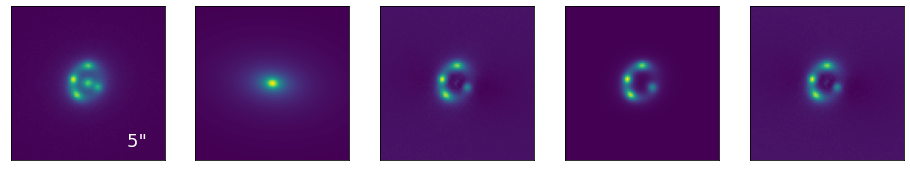

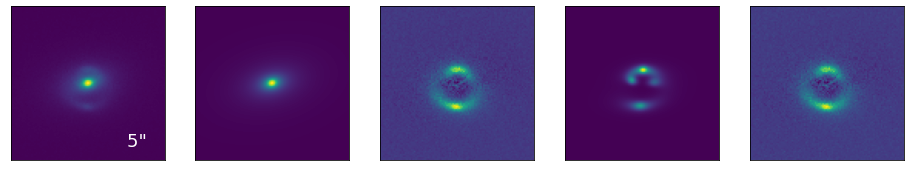

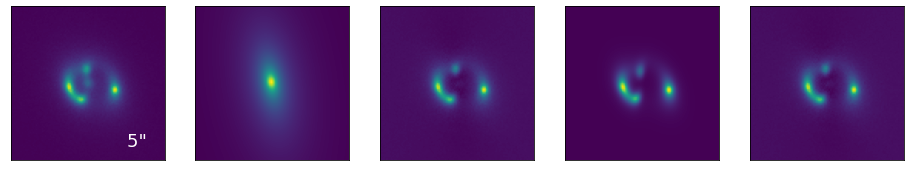

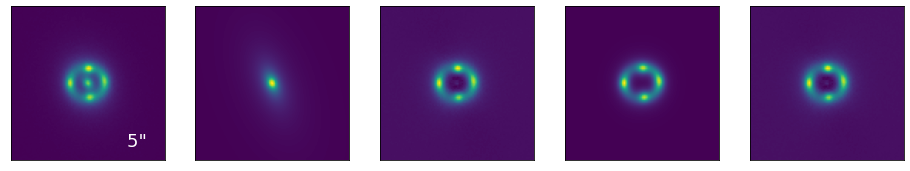

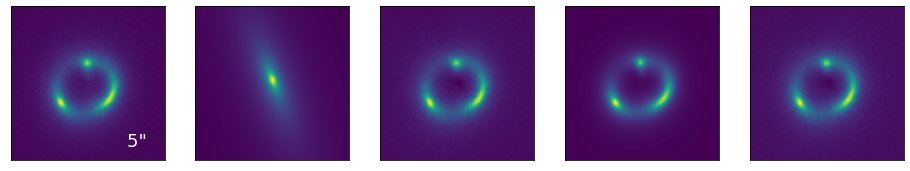

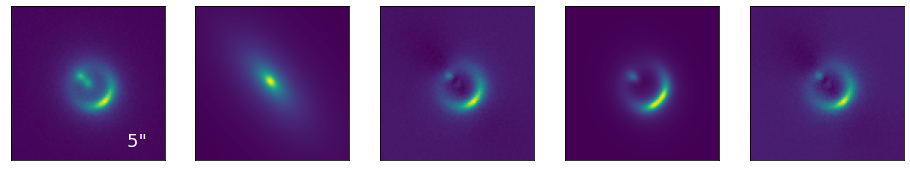

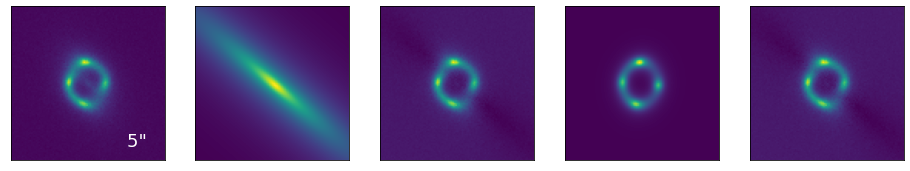

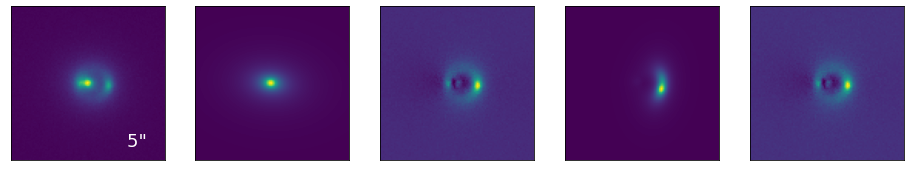

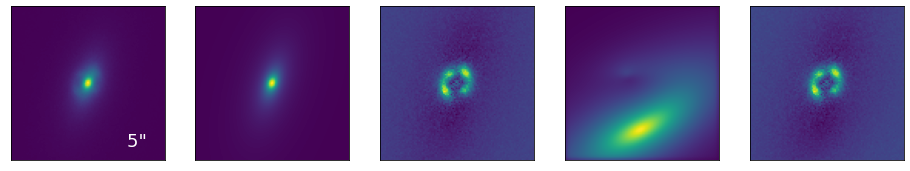

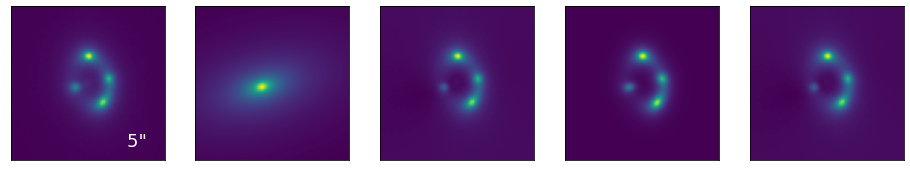

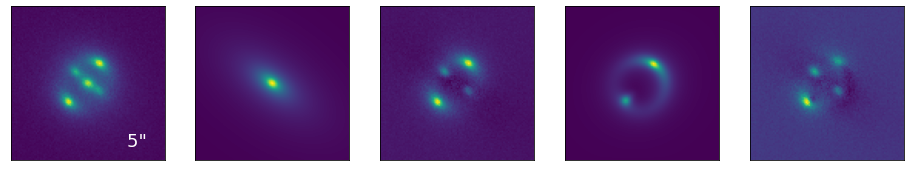

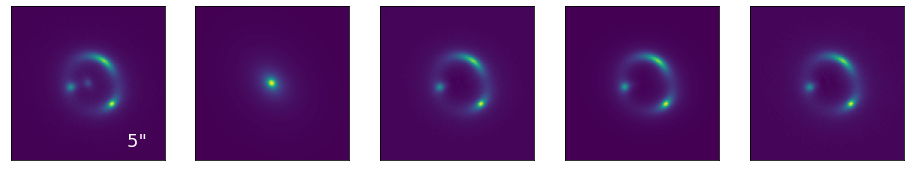

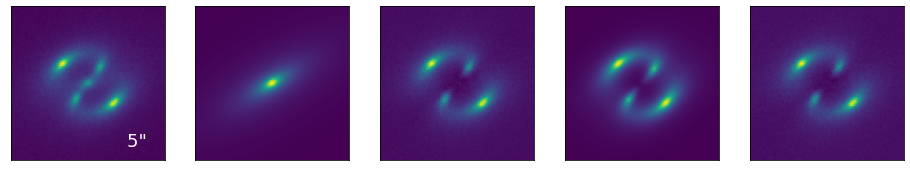

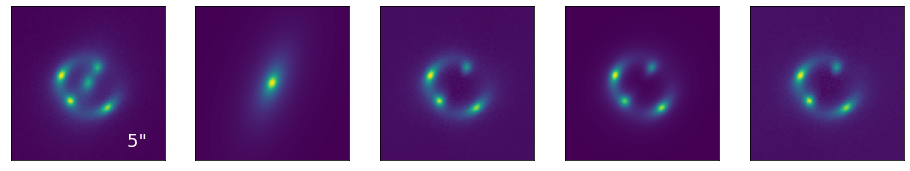

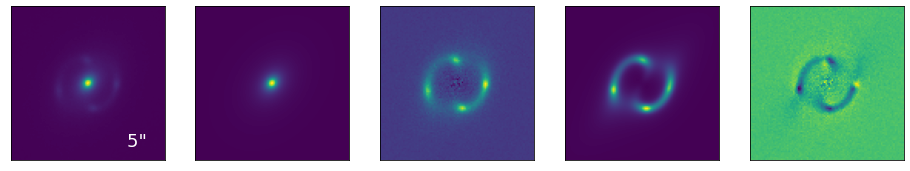

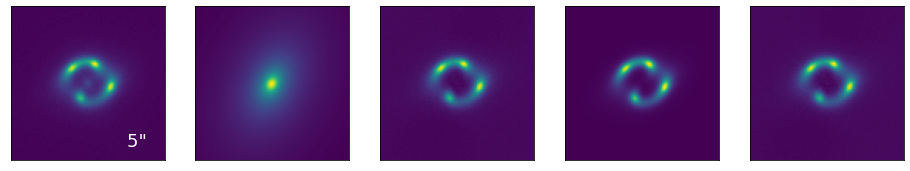

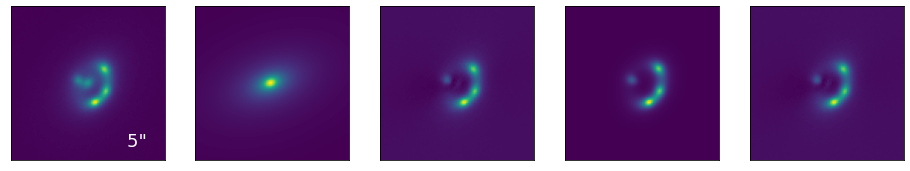

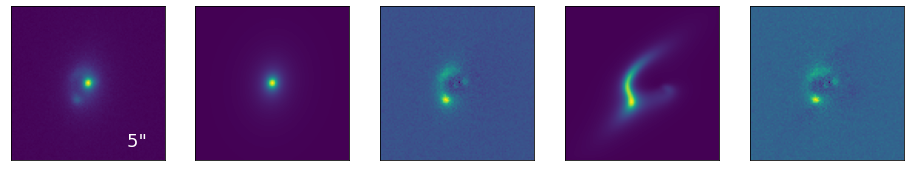

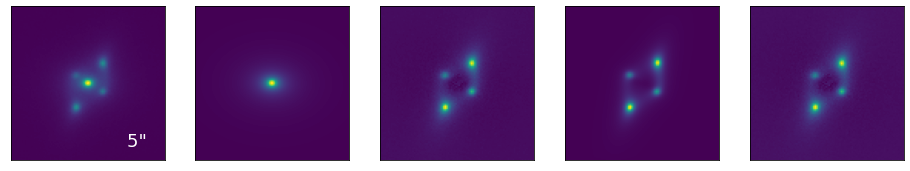

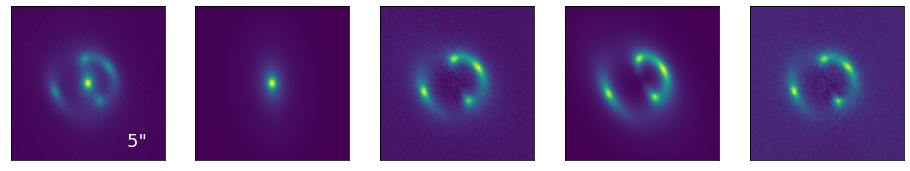

In [23]:
taking_time = []
start = time.time()
for i in range(0, N_sys):
    imaging_0 = al.Imaging(al.Array2D.manual(np.array(cutouts[i][2], dtype=float), pixel_scales=float(pixel_scale)), # cutout
                       al.Array2D.manual(np.array(noise_map[i][2], dtype=float), pixel_scales=float(pixel_scale)), # noise_map 
                       al.Kernel2D.manual(np.array(psf[i][2], dtype=float), pixel_scales=float(pixel_scale), shape_native=(100, 100))) # psf
    zl = bayes_sys_fit['PLANE_1-REDSHIFT-g'][i]
    zs = bayes_sys_fit['PLANE_2-REDSHIFT-g'][i]
    pipeline = apply_pipeline(imaging_0, i, zl, zs)
    result = apply_pipeline.fit_lens_light(pipeline, nlive=30, lens_light_radius=1.2)

    bayes_sys_fit['OBJID-g'][i] 
        
    result_modelization, image = pipeline.fit_system_lenstronomy(original_image=cutouts[i][2], background_rms=float(bayes_sys_fit['sky_brightness-'+str(bands_simulated[2])][i]), exposure_time=float(bayes_sys_fit['exposure_time-g'][0]), original_psf=psf[i][2], unmasked_lens_model=result.unmasked_model_image, pixel_scale=pixel_scale, prior_variables=variables, predictions_dataframe=dl_results[dl_results['sys']==bayes_sys_fit['OBJID-g'][i]], lower_limits=lower_sigma, upper_limits=upper_sigma, use_predictions=True)
    
    pipeline.reset_all()
    
    fig, ax = plt.subplots(1, 5,figsize=(16, 4))

    ax[0].imshow(cutouts[i][2])
    ax[0].text(75, 90, '5\" ', c='w', size=18)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].imshow(result.unmasked_model_image.reshape(100, 100))
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[2].imshow((imaging_0.image-result.unmasked_model_image).reshape(100, 100))
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    ax[3].imshow(image)
    ax[3].set_xticks([])
    ax[3].set_yticks([])
    ax[4].imshow((imaging_0.image-result.unmasked_model_image).reshape(100, 100)-image)
    ax[4].set_xticks([])
    ax[4].set_yticks([])

    fig.savefig('./imagens_lenstronomy/'+str(i)+'.png');
    
end = time.time()
taking_time.append(end - start)